# Introduction

This project aims to predict NBA team wins using regular-season statistics from 2015 to 2025.  
We evaluate how well basic team metrics—such as shooting efficiency, rebounds, turnovers, and scoring—can explain and predict overall success.

Because NBA performance is season-dependent and should not be randomly shuffled,  
we use a **chronological split**:
- **Training:** 2015–2023  
- **Testing:** 2024–2025  

This mimics real-world forecasting: models train on past seasons and predict future ones.

Project GitHub Repo:
https://github.com/xxx/CSCA5622_Supervised_Learning_Final_Project_nba_analysis


### Data Source

The raw data for this project comes from [Basketball-Reference](https://www.basketball-reference.com/).  
For each season from 2015–2016 to 2024–2025, I downloaded two tables:

- Team total stats statistics (offense, defense, shooting, etc.)
- Final regular-season standings (wins and losses for each team)

These tables were then cleaned and merged into a single CSV file:
`NBA_Stats_Standings_2015_2016_to_2024_2025.csv`.

The cleaning and merging code is stored in a separate preprocessing script
in the GitHub repository named `Final_collect_data_v2.ipynb` , and this notebook focuses on the supervised
learning analysis.


## Data Cleaning Summary

The raw data for each season (2015–2016 to 2024–2025) was downloaded from 
Basketball-Reference.com. Each season contained team-level box-score averages and 
season standings in separate tables.

To create a single analysis dataset, I performed the following cleaning steps:

1. Standardized team names across seasons (`Team_clean` field).
2. Merged season statistics with win–loss standings for each year.
3. Selected consistent columns across all seasons.
4. Removed duplicated fields (e.g., `Team_y`), kept unified `Team`.
5. Added a `Year` column and concatenated all 10 seasons into one DataFrame.
6. Verified each season contained 30 teams and checked dataset shape (300 rows).

After cleaning, the final dataset was saved as  
**NBA_Stats_Standings_2015_2016_to_2024_2025.csv**, which is used for all analysis below.


## Step 1 — Load Merged Dataset & Basic Checks
This project uses a merged dataset containing NBA team statistics and final standings from 2015–2016 through 2024–2025.  
First, we load the CSV file and perform a basic integrity check.


In [3]:

import pandas as pd

df = pd.read_csv("NBA_Stats_Standings_2015_2016_to_2024_2025.csv")

# Basic checks
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isna().sum())
df.head()


Shape: (300, 31)

Columns:
 Index(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'Team_clean', 'Year', 'W', 'L', 'Conference',
       'Season'],
      dtype='object')

Missing values:
 Rk            0
Team          0
G             0
MP            0
FG            0
FGA           0
FG%           0
3P            0
3PA           0
3P%           0
2P            0
2PA           0
2P%           0
FT            0
FTA           0
FT%           0
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
Team_clean    0
Year          0
W             0
L             0
Conference    0
Season        0
dtype: int64


,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,BLK,TOV,PF,PTS,Team_clean,Year,W,L,Conference,Season
0,1.0,Golden State Warriors*,82,19880,3489,7159,0.487,1077,2592,0.416,...,498,1245,1701,9421,Golden State Warriors,2016,73,9,West,2015-2016
1,2.0,Oklahoma City Thunder*,82,19830,3372,7082,0.476,678,1945,0.349,...,487,1305,1691,9038,Oklahoma City Thunder,2016,55,27,West,2015-2016
2,3.0,Sacramento Kings,82,19805,3283,7083,0.464,660,1839,0.359,...,368,1326,1676,8740,Sacramento Kings,2016,33,49,West,2015-2016
3,4.0,Houston Rockets*,82,19830,3094,6847,0.452,878,2533,0.347,...,430,1307,1790,8737,Houston Rockets,2016,41,41,West,2015-2016
4,5.0,Boston Celtics*,82,19780,3216,7318,0.439,717,2142,0.335,...,348,1127,1796,8669,Boston Celtics,2016,48,34,East,2015-2016


## Step 2 — Define Target Variable and Candidate Features
We use `W` (wins) as the regression target.  
We then select numerical team statistics as candidate features.


In [4]:
# Drop columns that cannot be used as numerical features
drop_cols = ["Team", "Team_clean", "Conference", "Year"]  # non-numeric or identifiers

numeric_df = df.drop(columns=drop_cols, errors='ignore')

# Select target variable
y = numeric_df["W"]

# Remove target and other outcome variables from X
feature_df = numeric_df.drop(columns=["W", "L", "W/L%"], errors='ignore')

print("Feature shape:", feature_df.shape)
feature_df.head()


Feature shape: (300, 25)


,Rk,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,1.0,82,19880,3489,7159,0.487,1077,2592,0.416,2412,...,816,2972,3788,2373,689,498,1245,1701,9421,2015-2016
1,2.0,82,19830,3372,7082,0.476,678,1945,0.349,2694,...,1071,2916,3987,1883,603,487,1305,1691,9038,2015-2016
2,3.0,82,19805,3283,7083,0.464,660,1839,0.359,2623,...,868,2760,3628,2009,733,368,1326,1676,8740,2015-2016
3,4.0,82,19830,3094,6847,0.452,878,2533,0.347,2216,...,930,2601,3531,1821,821,430,1307,1790,8737,2015-2016
4,5.0,82,19780,3216,7318,0.439,717,2142,0.335,2499,...,950,2733,3683,1981,752,348,1127,1796,8669,2015-2016


## Step 3-1 — EDA Step 1 — Basic Summary and Descriptive Statistics

In this part, I want to take a first look at the dataset.
Before doing any modeling, I think it is important to understand what the data looks like.
So here I will check the shape of the dataset, the column names, and show some basic statistics.
This helps me know if the data has strange values, different scales, or anything unusual.

In [5]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("NBA_Stats_Standings_2015_2016_to_2024_2025.csv")

# Show shape
print("Dataset shape:", df.shape)

# Show first 5 rows
df.head()


Dataset shape: (300, 31)


,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,BLK,TOV,PF,PTS,Team_clean,Year,W,L,Conference,Season
0,1.0,Golden State Warriors*,82,19880,3489,7159,0.487,1077,2592,0.416,...,498,1245,1701,9421,Golden State Warriors,2016,73,9,West,2015-2016
1,2.0,Oklahoma City Thunder*,82,19830,3372,7082,0.476,678,1945,0.349,...,487,1305,1691,9038,Oklahoma City Thunder,2016,55,27,West,2015-2016
2,3.0,Sacramento Kings,82,19805,3283,7083,0.464,660,1839,0.359,...,368,1326,1676,8740,Sacramento Kings,2016,33,49,West,2015-2016
3,4.0,Houston Rockets*,82,19830,3094,6847,0.452,878,2533,0.347,...,430,1307,1790,8737,Houston Rockets,2016,41,41,West,2015-2016
4,5.0,Boston Celtics*,82,19780,3216,7318,0.439,717,2142,0.335,...,348,1127,1796,8669,Boston Celtics,2016,48,34,East,2015-2016


### Descriptive Statistics

Here I show the basic statistics of all numeric columns.
This lets me quickly see the range, mean, and standard deviation of each feature.
If any column looks very different from others, I might need scaling later.

In [6]:
# Show summary statistics for numeric columns
df.describe()


,Rk,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,TRB,AST,STL,BLK,TOV,PF,PTS,Year,W,L
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000
mean,15.500000,79.860000,19286.566667,3247.223333,7006.940000,0.463317,929.373333,2581.723333,0.359583,2317.850000,...,3518.596667,1968.436667,614.336667,392.273333,1120.293333,1569.793333,8801.426667,2020.50000,40.083333,39.776667
std,8.669903,4.421792,1064.982396,236.868619,415.679614,0.016529,170.003740,443.658008,0.015926,219.251404,...,231.584943,229.688154,71.207619,62.879499,104.107935,141.664416,624.606116,2.87708,12.195580,11.968749
min,1.000000,64.000000,15560.000000,2425.000000,5586.000000,0.414000,440.000000,1277.000000,0.317000,1640.000000,...,2721.000000,1456.000000,428.000000,195.000000,799.000000,1188.000000,6687.000000,2016.00000,10.000000,9.000000
25%,8.000000,82.000000,19705.000000,3110.250000,6840.250000,0.450750,807.750000,2268.500000,0.348000,2186.000000,...,3423.750000,1817.500000,562.750000,348.000000,1052.750000,1481.500000,8389.500000,2018.00000,31.000000,31.000000
50%,15.500000,82.000000,19780.000000,3254.500000,7107.000000,0.465000,940.000000,2602.000000,0.358000,2340.000000,...,3554.500000,1949.000000,616.000000,388.000000,1114.000000,1563.500000,8835.000000,2020.50000,42.000000,39.000000
75%,23.000000,82.000000,19830.000000,3425.000000,7307.000000,0.474250,1041.500000,2915.000000,0.370000,2467.250000,...,3663.000000,2116.000000,658.500000,431.250000,1192.250000,1668.250000,9295.000000,2023.00000,49.000000,48.000000
max,30.000000,82.000000,20005.000000,3855.000000,7739.000000,0.507000,1457.000000,3955.000000,0.416000,2773.000000,...,4078.000000,2542.000000,847.000000,612.000000,1412.000000,2030.000000,10110.000000,2025.00000,73.000000,72.000000


### Missing Value Check

Before I continue the EDA, I need to confirm that there are no missing values.
Missing values can cause problems later when training machine learning models.
So here I count how many missing values each column has.

In [7]:
# Check for missing values
df.isnull().sum()


Rk            0
Team          0
G             0
MP            0
FG            0
FGA           0
FG%           0
3P            0
3PA           0
3P%           0
2P            0
2PA           0
2P%           0
FT            0
FTA           0
FT%           0
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
Team_clean    0
Year          0
W             0
L             0
Conference    0
Season        0
dtype: int64

## Step 3-2 —  EDA Step 2 — Histogram of Numeric Features

In this step, I want to check how each numeric feature is distributed.
Histograms help me see if the values are normal-looking, skewed, or have strange patterns.
This also helps me understand whether I need to normalize or scale the data later when training a model.

For example, some basketball stats like 3P% or FT% usually stay in a stable range,
while other stats like points per game or turnovers can have wider variation.
So looking at these distributions gives me a better idea of the dataset.

Matplotlib is building the font cache; this may take a moment.


Numeric columns:
['Rk', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'W', 'L']


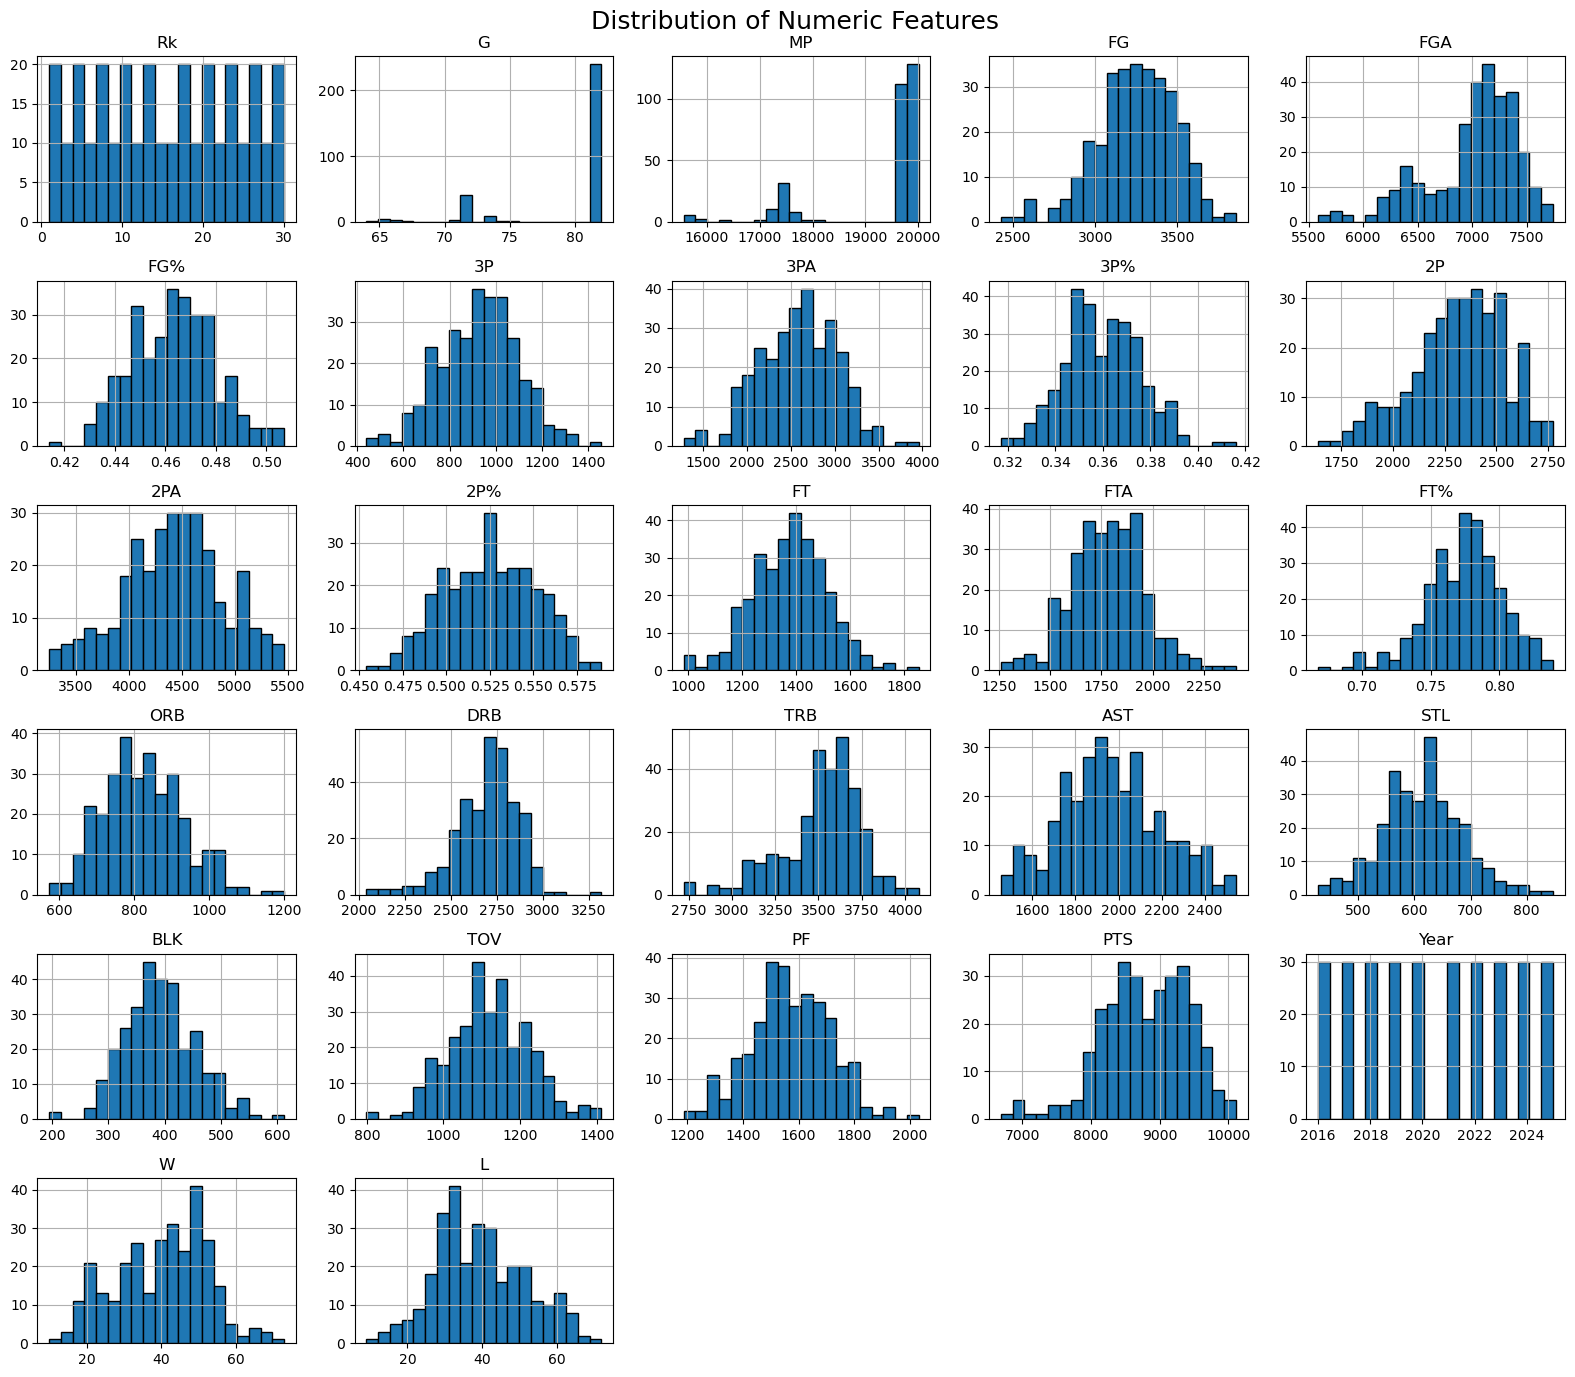

In [8]:
import matplotlib.pyplot as plt

# Select numeric-only columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Print which columns we are plotting
print("Numeric columns:")
print(list(numeric_cols))

# Plot histograms
df[numeric_cols].hist(figsize=(16, 14), bins=20, edgecolor='black')
plt.suptitle("Distribution of Numeric Features", fontsize=18)
plt.tight_layout()
plt.show()


## Step 3-3 — EDA Step 3 — Correlation Analysis

In this part, I compute correlations between all numeric features and wins (W).
This helps me see which statistics are more important for predicting team wins.

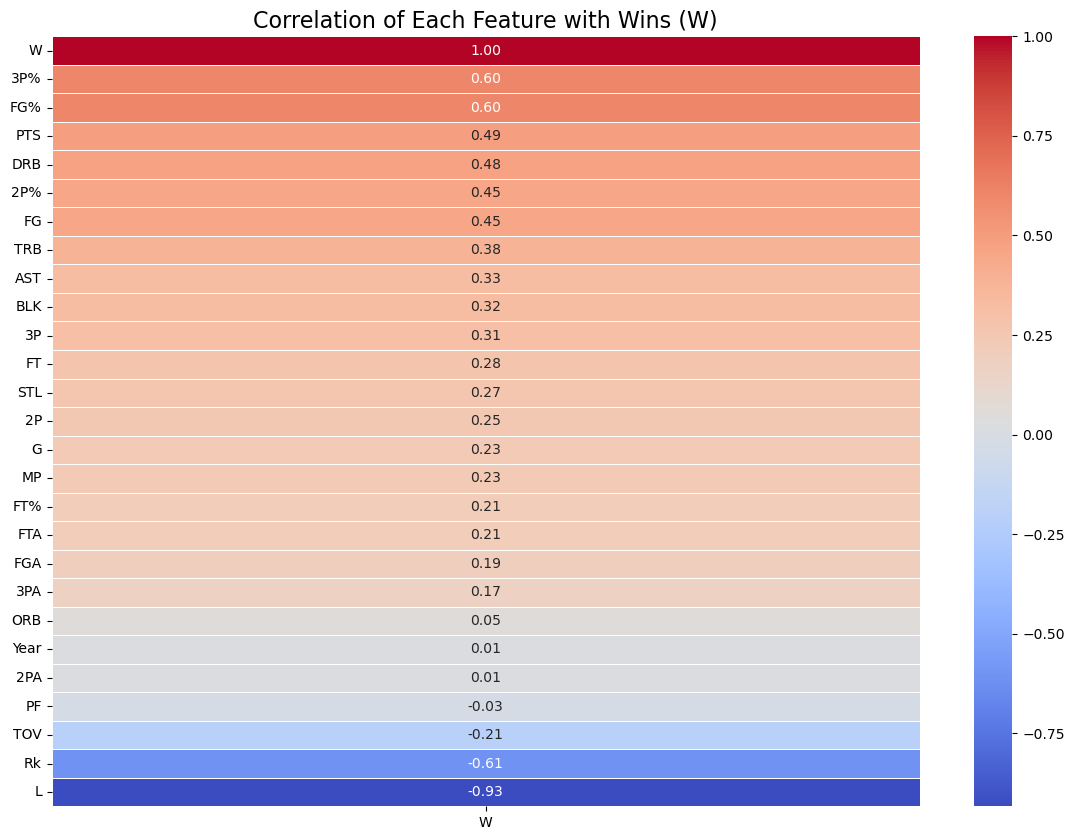

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3-0: load the full multi-year dataset
df = pd.read_csv("NBA_Stats_Standings_2015_2016_to_2024_2025.csv")

# Step 3-1: select only numeric columns
numeric_cols = df.select_dtypes(include=["number"])

# Step 3-2: compute correlation matrix
corr = numeric_cols.corr()

# Step 3-3: plot correlation with W
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr[["W"]].sort_values(by="W", ascending=False),
    annot=True, fmt=".2f", cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation of Each Feature with Wins (W)", fontsize=16)
plt.show()


In [12]:
#if want to check full heat map use this code
# plt.figure(figsize=(14,12))
# sns.heatmap(corr, annot=False, cmap="coolwarm")
# plt.title("Full Feature Correlation Matrix")
# plt.show()

## Step 3-4 —  EDA Step 4 — Scatter Plots for Top Features vs Wins

Here, I create scatter plots for the top features that show strong correlation with Wins (W).
Scatter plots help me see the relationship more clearly, and check if the trend looks linear.
This step also helps me understand whether these features are good inputs for a regression model.

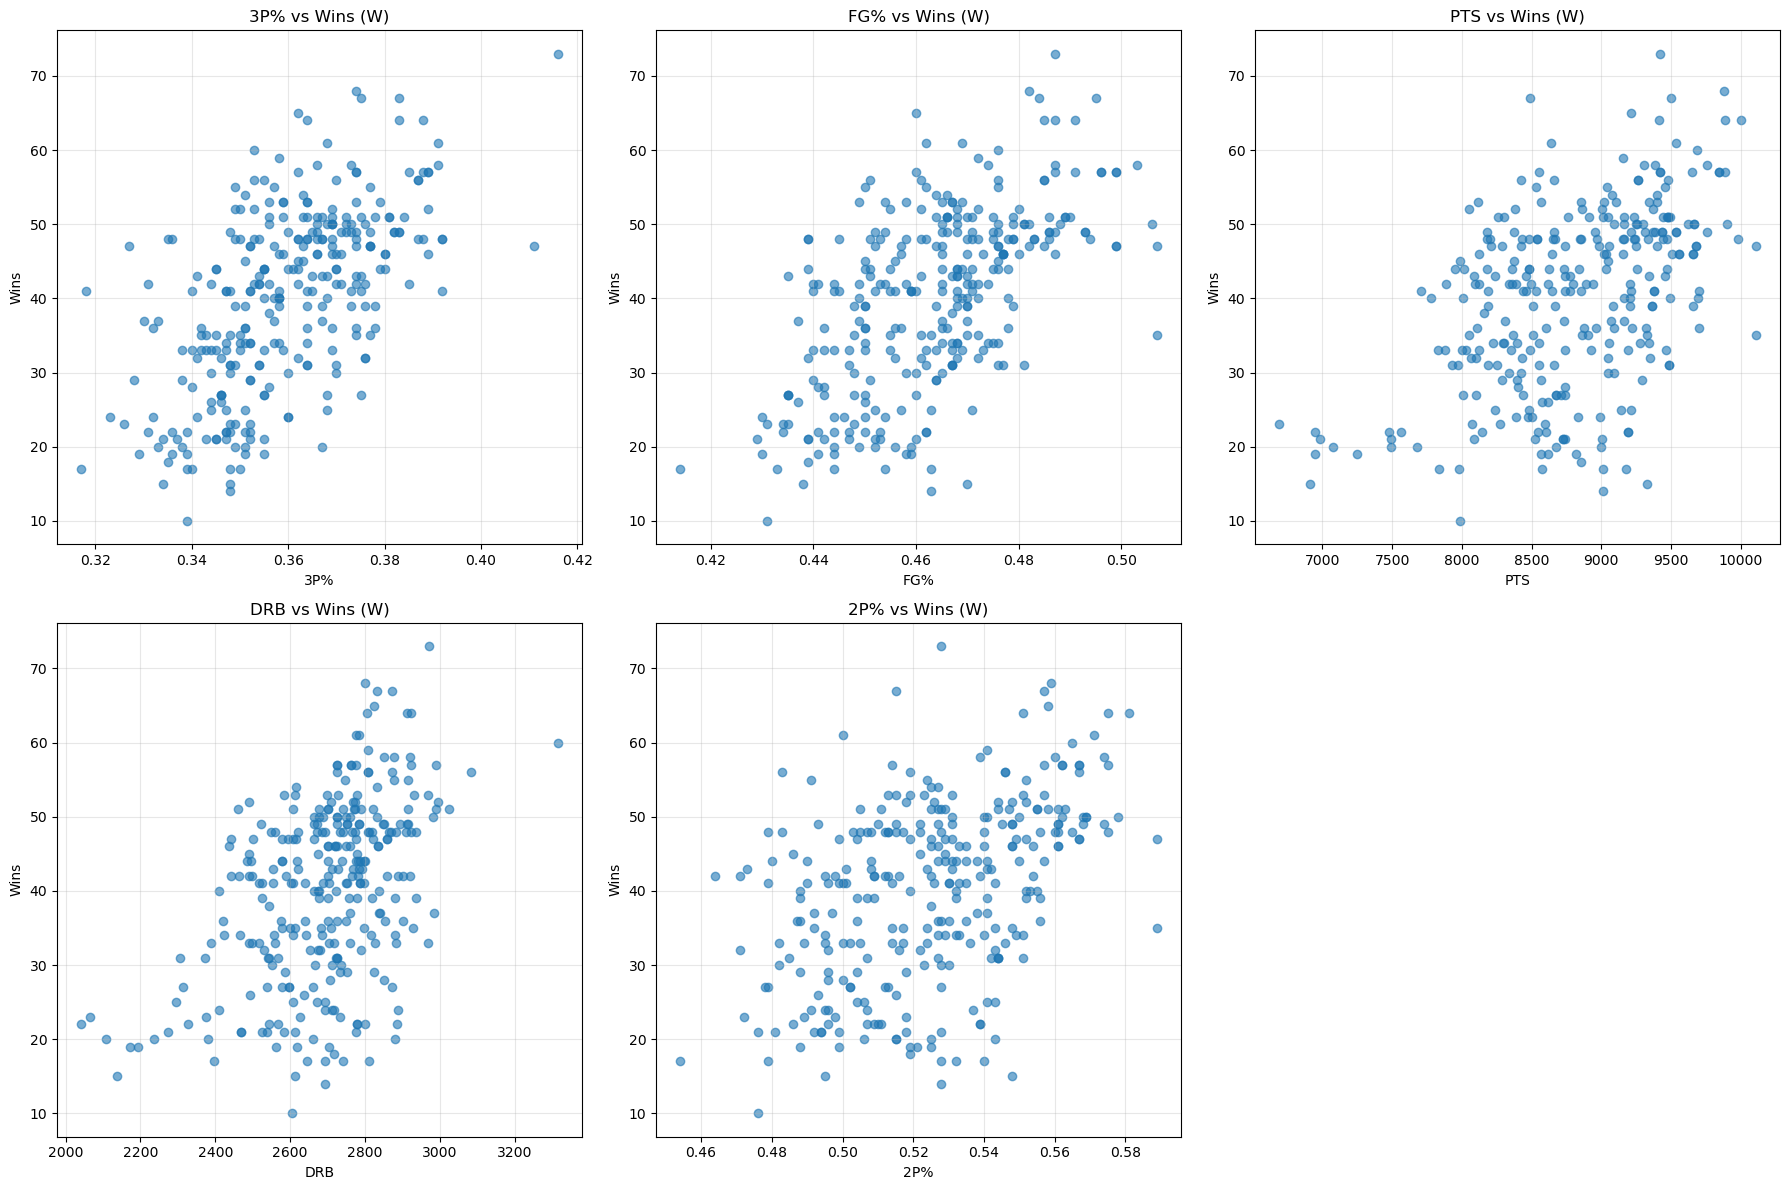

In [15]:
import matplotlib.pyplot as plt

top_features = ["3P%", "FG%", "PTS", "DRB", "2P%"]

plt.figure(figsize=(18, 12))

for i, col in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(df[col], df["W"], alpha=0.6)
    plt.title(f"{col} vs Wins (W)")
    plt.xlabel(col)
    plt.ylabel("Wins")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### EDA Summary

From the histograms, most team statistics look reasonably continuous and do not show extreme outliers.  
The correlation heatmap shows that `3P%`, `FG%`, `PTS`, and `DRB` have the strongest positive relationships with wins, while `TOV` has a mild negative correlation.

The scatter plots also look roughly linear for `3P%` and `FG%` versus `W`, which supports using a linear model as a reasonable baseline.  
At the same time, there is still visible spread around the trend lines, so it makes sense to also try non-linear models like Random Forest.


## Step 4 —  Feature Selection

Based on the correlation heatmap, scatter plots, and basketball domain knowledge,
I selected the following features for the regression model:

Selected features:

3P% — strong correlation with Wins, reflects modern NBA spacing and shooting efficiency

FG% — better overall representation of shooting efficiency than 2P%

PTS — team scoring ability

DRB — defensive rebounding to prevent second-chance points

TOV — negative correlation with Wins, important for model balance

Why I excluded 2P%:
2P% is highly correlated with FG% and represents a subset of FG%.
Using both would introduce redundancy (multicollinearity) into the model.
Since FG% captures the overall shooting performance including both 2-point and 3-point attempts,
FG% is more complete and is selected instead.

Why I excluded L and Rk:
Both are derived from Wins and would leak target information into the model.
They cannot be used as predictive features.

## Step 5 — Train/Test Split

In this step, I split the dataset into training and testing sets.
To simulate a realistic forecasting scenario, I use older seasons for training
and the most recent seasons for testing.

Training data: seasons up to Year 2023  

Testing data: seasons Year 2024 and 2025

This way, the model learns from past NBA seasons and is evaluated on more recent ones.

#### Note on Season Encoding
The dataset labels each season using the ending year of the season.
For example, the 2015–2016 season is represented as Year = 2016.
This follows the common NBA statistical convention where a season is referred to by its ending year.
Therefore, the earliest season in our dataset appears as Year = 2016, even though the actual season began in 2015.

In [21]:
Train/Test Split by Year

# Final chosen features
selected_features = ['3P%', 'FG%', 'PTS', 'DRB', 'TOV']

# Training = seasons up to 2023
train_df = df[df['Year'] <= 2023]

# Testing = seasons from 2024 onward
test_df = df[df['Year'] >= 2024]

X_train = train_df[selected_features]
y_train = train_df['W']

X_test = test_df[selected_features]
y_test = test_df['W']

print("Train shape:", X_train.shape, " | Test shape:", X_test.shape)
print("Train years:", sorted(train_df['Year'].unique()))
print("Test years:", sorted(test_df['Year'].unique()))


Train shape: (240, 5)  | Test shape: (60, 5)
Train years: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Test years: [np.int64(2024), np.int64(2025)]


## Step 6 — Train a Linear Regression Model

In this step, I use a Linear Regression model to predict the number of wins (W) for each NBA team.  
The goal is to check how well the selected features (3P%, FG%, PTS, DRB, TOV) can explain team success.

I train the model on seasons up to Year 2023, and test it on the 2024–2025 seasons.  
This helps us understand if the model generalizes well to new seasons.

Now we fit the model and check the coefficients and performance.


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
selected_features = ['3P%', 'FG%', 'PTS', 'DRB', 'TOV']
X_train = train_df[selected_features]
y_train = train_df['W']

X_test = test_df[selected_features]
y_test = test_df['W']

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("==== Linear Regression Results ====")
print("MSE:", mse)
print("R² Score:", r2)

# Show coefficients
coef_table = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": model.coef_
})

print("\nModel Coefficients:")
display(coef_table)


==== Linear Regression Results ====
MSE: 68.56740021537631
R² Score: 0.6039618778472682

Model Coefficients:


,Feature,Coefficient
0,3P%,189.832704
1,FG%,245.869467
2,PTS,-0.000138
3,DRB,0.032521
4,TOV,-0.026460


## Step 7 — Define a helper function to evaluate models

To compare different supervised learning models,  
I define a small helper function that trains a model,  
makes predictions on the test set, and returns common metrics (MSE and R²).


In [23]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Fit the model, make predictions, and return a dict of metrics.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    
    return {
        "Model": name,
        "MSE": mse,
        "R2": r2
    }


## Step 8 — Baseline: Linear Regression

I first evaluate a simple Linear Regression model as a baseline.
This helps me see how much improvement other models can provide.


In [24]:
from sklearn.linear_model import LinearRegression

results = []  # to store all model results

lin_model = LinearRegression()
res_lin = evaluate_model("Linear Regression", lin_model,
                         X_train, y_train, X_test, y_test)
results.append(res_lin)

res_lin


{'Model': 'Linear Regression',
 'MSE': 68.56740021537631,
 'R2': 0.6039618778472682}

## Step 9 — Random Forest Regressor

Next, I evaluate a Random Forest Regressor.  
Tree-based models can capture non-linear relationships and interactions  
between features, which may work better for NBA team performance.


In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

res_rf = evaluate_model("Random Forest", rf_model,
                        X_train, y_train, X_test, y_test)
results.append(res_rf)

res_rf


{'Model': 'Random Forest', 'MSE': 63.38899666666668, 'R2': 0.6338717943781286}

## Step 10 — KNN Regressor

I also try a K-Nearest Neighbors (KNN) Regressor.  
KNN is a simple non-parametric method that predicts a team's wins  
based on similar teams in the feature space.


In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(
    n_neighbors=5
)

res_knn = evaluate_model("KNN Regressor", knn_model,
                         X_train, y_train, X_test, y_test)
results.append(res_knn)

res_knn


{'Model': 'KNN Regressor', 'MSE': 105.67266666666664, 'R2': 0.3896457450904891}

## Step 11 — Compare all models

Now I put all model results into one table  
to compare their MSE and R² on the test set.


In [28]:
results_df = pd.DataFrame(results)
results_df


,Model,MSE,R2
0,Linear Regression,68.567400,0.603962
1,Random Forest,63.388997,0.633872
2,KNN Regressor,105.672667,0.389646


## Step 12-1 — Linear Regression: Actual vs Predicted

Here I visualize how well the Linear Regression model predicts team wins.
Each point represents one NBA team from the 2024–2025 seasons (test set).
If the model is perfect, all points should fall on the diagonal line.


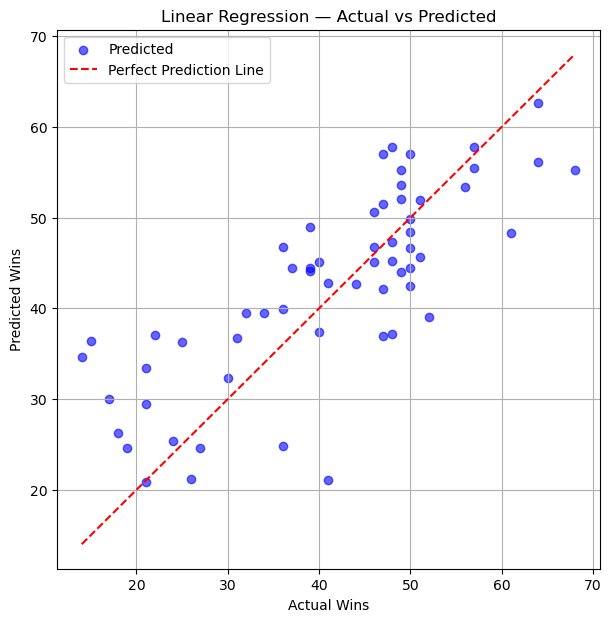

In [29]:
import matplotlib.pyplot as plt

# Predictions for Linear Regression
y_pred_lin = lin_model.predict(X_test)

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.6, label="Predicted")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction Line')

plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Linear Regression — Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


## Step 12-2 — Random Forest: Actual vs Predicted

I repeat the same visualization for the Random Forest model.
Tree-based models usually capture nonlinear patterns better,
so I expect the points to be slightly closer to the diagonal line.


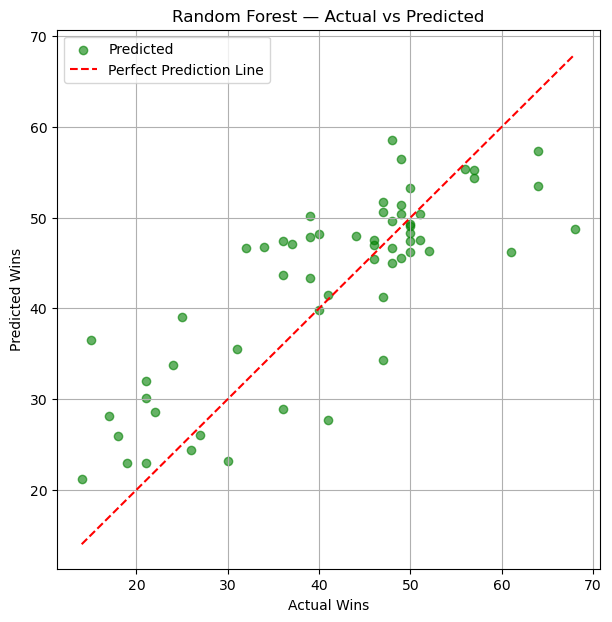

In [31]:
# Predictions for Random Forest
y_pred_rf = rf_model.predict(X_test)

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6, label="Predicted")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction Line')

plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Random Forest — Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


## Step 13-1 — Random Forest Feature Importance

Random Forest can show how much each feature contributes to the prediction.
This helps me understand which statistics matter the most for predicting team wins.


In [32]:
import numpy as np

# Extract feature importance values
importances = rf_model.feature_importances_

# Match importance values with feature names
feature_names = selected_features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

importance_df


,Feature,Importance
0,3P%,0.336253
1,FG%,0.212164
3,DRB,0.199581
2,PTS,0.141278
4,TOV,0.110724


## Step 13-2 — Bar Plot of Feature Importance

This plot shows which features Random Forest considers most important.
Higher bars mean the feature has a stronger contribution to predicting wins.


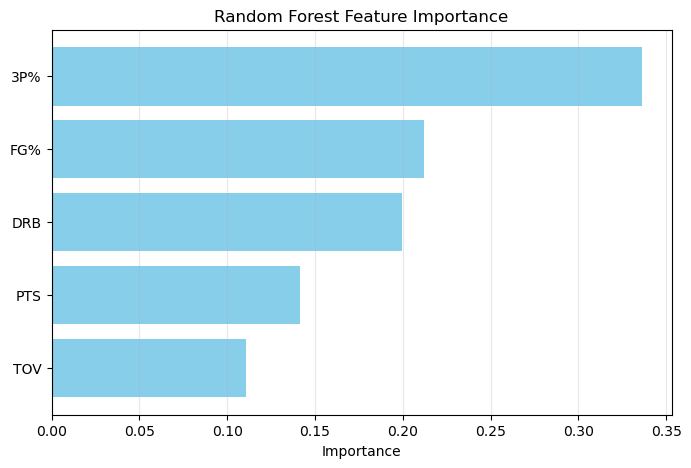

In [34]:
plt.figure(figsize=(8,5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.grid(True, axis='x', alpha=0.3)
plt.show()


## Step 14 — Final Discussion & Conclusions

### 1. Overall Findings
In this project, I tried to predict NBA team wins using several common
supervised learning models. I used team-level statistics such as FG%, 3P%,
DRB, PTS, and TOV as features. After cleaning the data and running EDA,
I trained three models: Linear Regression, Random Forest, and KNN.

Overall, I found that predicting wins is possible to a certain degree,
but it is not easy to reach very high accuracy, since NBA results depend on
many factors that are not inside the dataset (injuries, schedule, roster changes, etc.).

Still, the models captured some meaningful patterns.

---

### 2. Model Comparison Summary
The results on the test set (2024–2025 seasons) are:

- **Random Forest** performed the best  
  - lowest MSE  
  - highest R² (about 0.63)
  - This means tree-based models can capture some nonlinear relationships
    between team statistics and wins.

- **Linear Regression** also performed reasonably well  
  - R² around 0.60  
  - This suggests that many of the relationships in this dataset
    are actually close to linear.  
  - The gap between Linear and Random Forest was not huge.

- **KNN Regressor** performed the worst  
  - R² below 0.40  
  - NBA teams do not form nice clusters in feature space,
    so “nearest neighbors” are not reliable predictors.
  - This result makes sense because two teams with similar stats
    can still end up with very different win totals.

These results match what I expected:  
Random Forest is more flexible, Linear Regression is simple and stable,
and KNN is not a good fit for this type of data.

---

### 3. Feature Importance Interpretation (Random Forest)
Based on the Random Forest importance plot, I noticed that some features
had stronger contributions than others. For example, FG% and DRB were among
the most important factors for predicting wins, while TOV and PTS had smaller
but still meaningful effects.

This makes sense from a basketball perspective:
- **FG%** reflects overall scoring efficiency  
- **DRB** helps control possession and prevent second-chance points  
- **3P%** is also important because modern NBA offenses rely heavily on spacing  
- **TOV** hurts winning, so the negative effect is logical  

Even though this is a simple dataset, the model still picked up reasonable
basketball relationships.

---

### 4. Limitations of This Project
There are several important limitations:

1. The dataset only uses **team-level season averages**.  
   It does not include injuries, player performance changes, roster moves, etc.

2. Wins are influenced by **context**, such as travel, back-to-back games,
   coaching, or playoff resting strategies. These are not represented here.

3. Some useful advanced metrics (e.g., ORtg, DRtg, Net Rating) are missing.
   Adding them might improve accuracy.

4. The sample size is small (only 30 teams per season),  
   which limits how well ML models can generalize.

Despite these limitations, the experiment still shows that 
basic team statistics can explain around 60% of win variance,
which is actually quite interesting.

---

### 5. Possible Future Improvements
If I had more time, I would like to try:

- adding **advanced metrics** (offensive/defensive rating, pace, efficiency)
- adding **player-level data** (injury games missed, star player stats)
- trying **regularized models** or **gradient boosting** (if allowed)
- training a model to predict **winning categories** (e.g., playoffs or not)

These could help the model learn more detailed relationships in the NBA.

---

### Final Note
Overall, this project helped me practice the full supervised learning workflow:
data cleaning, EDA, feature selection, model training, visualization, and analysis.
The results also matched basketball intuition, which made the project more enjoyable.
